In [0]:
import json
import pandas as pd
import numpy as np
import nltk
import spacy
from datetime import datetime
import gensim
import gensim.corpora as corpora
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import get_tmpfile, datapath
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings("ignore")

In [3]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
 # Each JSON is a row
df = pd.DataFrame()
number_of_files = 52
for i in range(1,number_of_files):
    file = open(f"articles/{i}.json", 'r')
    s = file.read()
    data = json.loads(s)
    dfi = pd.DataFrame([data])
    df = pd.concat([df, dfi], ignore_index=True)

# Saving df as a pickle
df.to_pickle('./data.pkl')

In [0]:
df = pd.read_pickle('./data.pkl')

In [6]:
df.head()

,article_ID,publish_date,title,body
0,20200410T050501Z,2020/04/10,Chinese government reveals draft list of anima...,#Chinese government reveals draft list of anim...
1,20200410T051106Z,2020/04/10,China is on a knife edge between recovery and ...,#China is on a knife edge between recovery and...
2,20200409T092729Z,2020/04/09,Saudi Arabia declares ceasefire in Yemen over ...,#Saudi Arabia declares ceasefire in Yemen over...
3,20200410T062323Z,2020/04/10,Sweden challenges Trump -- and scientific main...,#Sweden challenges Trump -- and scientific mai...
4,20200410T143649Z,2020/04/10,"Spain is 'not yet in de-escalation phase,' hea...","#Spain is 'not yet in de-escalation phase,' he..."


In [0]:
# Helper Functions

def article_to_words(articles):
    '''tokenizes articles; yeilds list of words for each article'''
    for article in articles:
        yield(gensim.utils.simple_preprocess(article, deacc=True))  
        
def remove_stopwords(texts):
    stop_words = stopwords.words('english')
    stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'say', 'also', 'would', 'may'])
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    '''Applies the bigram model(defined below) on each document'''
    return [bigram_mod[doc] for doc in texts]

nlp = spacy.load('en', disable=['parser', 'ner'])
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [0]:
def preprocess(df):
    '''
    Input: clean dataframe
    Output: list of articles after preprocess, bigram model
    '''
    
    articles = list(df['body'])                                         
    data_words = list(article_to_words(articles))                        
    
    common_terms = ["of", "with", "without", "and", "or", "the", "a"]
    bigram = gensim.models.Phrases(data_words, 
                                   min_count=4, 
                                   threshold=30, 
                                   common_terms=common_terms)            
    bigram_mod = gensim.models.phrases.Phraser(bigram)                   
    
    return data_words, bigram_mod

In [0]:
data_words, bigram_mod = preprocess(df)

data_words_lemmatized = lemmatization(data_words)
data_words_nostops = remove_stopwords(data_words_lemmatized)
data_final = make_bigrams(data_words_nostops)

In [0]:
word_dict = corpora.Dictionary(data_final)

corpus = [word_dict.doc2bow(text) for text in data_final] 

In [11]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=word_dict,
                                           num_topics=num_topics,
                                           random_state=100,
                                           passes=20,
                                           per_word_topics=True,
                                           workers=25)
        model_list.append(model)
        coherencemodel = gensim.models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        print(num_topics)

    return model_list, coherence_values

start=5; limit=30; step=5
model_list, coherence_values = compute_coherence_values(dictionary=word_dict, corpus=corpus, texts=data_final, start=start, limit=limit, step=step)

5
10
15
20
25


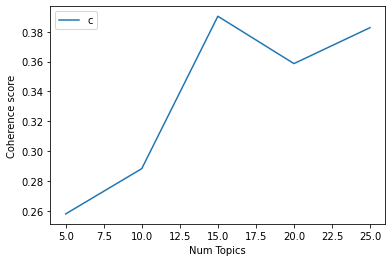

In [12]:
import matplotlib.pyplot as plt
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

The coherence value seems to be highest (~0.52) for 15 topics

In [18]:
model_lda = model_list[coherence_values.index(max(coherence_values))]  # Model with highest coherence
model_lda.show_topics(-1)

[(0,
  '0.027*"image" + 0.010*"see" + 0.010*"junocam" + 0.008*"orbit" + 0.008*"mission" + 0.008*"camera" + 0.008*"public" + 0.007*"look" + 0.006*"process" + 0.006*"photograph"'),
 (1,
  '0.047*"tree" + 0.013*"city" + 0.010*"people" + 0.009*"favela" + 0.007*"home" + 0.007*"take" + 0.006*"study" + 0.005*"include" + 0.005*"water" + 0.005*"year"'),
 (2,
  '0.015*"country" + 0.007*"animal" + 0.006*"people" + 0.006*"state" + 0.006*"happiness" + 0.005*"crisis" + 0.005*"well" + 0.005*"member" + 0.005*"health" + 0.004*"make"'),
 (3,
  '0.016*"food" + 0.009*"country" + 0.009*"pandemic" + 0.008*"people" + 0.008*"company" + 0.007*"crisis" + 0.007*"business" + 0.007*"even" + 0.006*"could" + 0.005*"need"'),
 (4,
  '0.034*"mask" + 0.020*"reef" + 0.015*"wear" + 0.008*"coral" + 0.007*"face" + 0.007*"need" + 0.007*"scientist" + 0.006*"take" + 0.006*"time" + 0.005*"city"'),
 (5,
  '0.017*"toilet" + 0.012*"hare" + 0.012*"water" + 0.011*"chicken" + 0.009*"waste" + 0.007*"year" + 0.005*"find" + 0.005*"accor

In [27]:
%matplotlib inline
import pyLDAvis
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(topic_model=model_lda, corpus=corpus, dictionary=word_dict)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)